In [1]:
import sys

sys.path.append('/home/radlr/anaconda3/envs/lVGPU2/lib/python3.6/site-packages')

#hint from https://stackoverflow.com/questions/19876079/opencv-cannot-find-module-cv2

# math etc.
from scipy import misc
import numpy as np

#plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

#image functions, esp. resizing
import cv2
#directory functions
import os

import tensorflow as tf
import time

%store -r myImgs
%store -r myTargets
print(np.shape(myImgs))
print(np.shape(myTargets))
print(np.max(myImgs))

myImgs = np.array(myImgs/np.max(myImgs))
myTargets = np.array(myTargets/np.max(myTargets))


(2636, 48, 64, 3)
(2636, 1)
255


In [2]:
def cuttleVision(cSpher,fN,nStk,off,defCo):
    img = 1.0*misc.imread(fN)
    sBNarrower = 1.0*misc.imread('./sBandiensisNarrower-1.tif')
    sBNarrow = 1.0*misc.imread('./sBandiensisNarrow-1.tif')
    sBFull = 1.0*misc.imread('./sBandiensisFuller-1.tif')
    
    dimX = np.shape(sBNarrower)[0]
    mid = dimX/2
    dimImg = np.shape(img)[0]
    
    N = 12.5 #25mm eye
    x1, y1 = np.meshgrid(np.arange(-N,N-N/dimX,2*N/dimX),np.arange(-N,N-N/dimX,2*N/dimX))
    
    rad = np.sqrt(x1**2+y1**2)
    
    apDef = np.exp(np.sqrt(3)*(2*rad**2-1))
    apSpher = np.exp(np.sqrt(5) * (6*rad**4 - 6*rad**2+1))
    
    nStk = 2 # three focus depths
    
    
    imgStack = np.zeros([dimImg,dimImg,3])
    
    myPSFDim = 48
    PSF = np.zeros([myPSFDim*2,myPSFDim*2,9])
    
    for c in range(0,nStk+1):
        
        cChromR = 1 - (c / (nStk))
        cChromB = 1.0 - cChromR
        cChromG = 0.5 - cChromR
        if (0):
            apR1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromR*defCo*apDef+cSpher*apSpher));
            apG1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromG*defCo*apDef+cSpher*apSpher));
            apB1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromB*defCo*apDef+cSpher*apSpher));
        if(1):
            apR1 = (sBFull) * np.exp(1j*2*np.pi*(cChromR*defCo*apDef+cSpher*apSpher));
            apG1 = (sBFull) * np.exp(1j*2*np.pi*(cChromG*defCo*apDef+cSpher*apSpher));
            apB1 = (sBFull) * np.exp(1j*2*np.pi*(cChromB*defCo*apDef+cSpher*apSpher));
        
        apR1 = np.nan_to_num(apR1)
        apG1 = np.nan_to_num(apG1)
        apB1 = np.nan_to_num(apB1)
                
        PSF1R = np.abs(np.fft.fft2(apR1))**2
        PSF1G = np.abs(np.fft.fft2(apG1))**2
        PSF1B = np.abs(np.fft.fft2(apB1))**2
        
        #normalize PSFs
        if (0):
            PSF1R = PSF1R/np.max(np.max(PSF1R)); #%abs(fft(apR1)).^2;
            PSF1G = PSF1G/np.max(np.max(PSF1G));
            PSF1B = PSF1B/np.max(np.max(PSF1B));
        
        tempR = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,0],[dimX,dimX])*np.fft.fft2(PSF1R)))
        tempG = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,1],[dimX,dimX])*np.fft.fft2(PSF1G)))
        tempB = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,2],[dimX,dimX])*np.fft.fft2(PSF1B)))
        
        tempR = (tempR - np.min(tempR)) / np.max(tempR)
        tempG = (tempG - np.min(tempG)) / np.max(tempG)
        tempB = (tempB - np.min(tempB)) / np.max(tempB)
        
        tempR = tempR[0:dimImg,0:dimImg]
        tempG = tempG[0:dimImg,0:dimImg]
        tempB = tempB[0:dimImg,0:dimImg]
        
        myPSFDim = 48
        PSF1R = np.fft.fftshift(PSF1R)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1G = np.fft.fftshift(PSF1G)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1B = np.fft.fftshift(PSF1B)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        
        imgStack[:,:,c] = tempR + tempG + tempB
        if(0):
            imgStack[:,:,c*3+0] = tempR
            imgStack[:,:,c*3+1] = tempG
            imgStack[:,:,c*3+2] = tempB
        if(1):
            PSF[:,:,c*3+0] = PSF1R
            PSF[:,:,c*3+1] = PSF1G
            PSF[:,:,c*3+2] = PSF1B
        if (0): #plot for debugging/testing defocus parameters
            plt.figure(figsize=(12,12))
            plt.subplot(321)
            plt.imshow(tempR,cmap='gray')
            plt.subplot(322)
            plt.imshow(tempG,cmap='gray')
            plt.subplot(323)
            plt.imshow(tempB,cmap='gray')
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
            myImgRGB = np.zeros([dimImg,dimImg,3])
            myImgRGB[:,:,0] = tempR
            myImgRGB[:,:,1] = tempG
            myImgRGB[:,:,2] = tempB
            plt.figure(figsize=(6,6))
            plt.imshow(myImgRGB)
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
    return imgStack, PSF

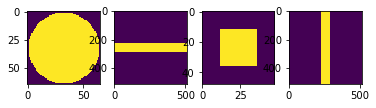

In [3]:
kSize = 65
myKernel = np.zeros([kSize,kSize])
for cx in range(kSize):
    for cy in range(kSize):
        
        if (np.sqrt((cx-kSize/2)**2+(cy-kSize/2)**2)<=(kSize/2-1)):
            myKernel[cx,cy] = 1.0

kSize2 = 512
myKernel2 = np.zeros([kSize2,kSize2])
for cx in range(kSize2):
    for cy in range(kSize2):
        
        if (np.sqrt((cx-kSize2/2)**2)<=(kSize2/16-1)):
            myKernel2[cx,cy] = 1.0

myKernel4 = np.zeros([kSize2,kSize2])
for cx in range(kSize2):
    for cy in range(kSize2):
        
        if (np.sqrt((cx-kSize2/2)**2)<=(kSize2/16-1)):
            myKernel4[cy,cx] = 1.0
            
kSize3 = 48
myKernel3 = np.zeros([kSize3,kSize3])
myKernel3[12:36,12:36] = 1     
plt.figure()
plt.subplot(141)
plt.imshow(myKernel)
plt.subplot(142)
plt.imshow(myKernel2)
plt.subplot(143)
plt.imshow(myKernel3)
plt.subplot(144)
plt.imshow(myKernel4)
plt.show()
#help(np.fft.fft2)

/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


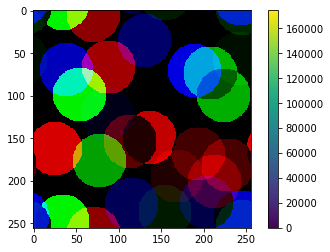

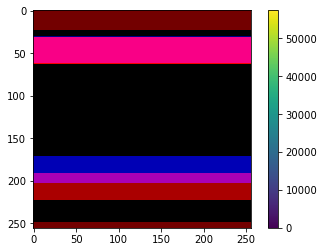

(1024, 256, 256, 3)


In [13]:
#Generate random RGB images
myDimSm = 256
myDimFl = 256
simgStkNo = 1024

#make it deterministic
np.random.seed(3)
simgStk = np.zeros([simgStkNo,myDimSm,myDimSm,3])
for c in range(0,simgStkNo):
    if(c <= simgStkNo/4):
        myTestR = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0001)
        myTestG = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0001)
        myTestB = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0001)
        myTestR = np.fft.ifft2(np.fft.fft2(myTestR,[myDimFl,myDimFl])*np.fft.fft2(myKernel,[myDimFl,myDimFl]))
        myTestG = np.fft.ifft2(np.fft.fft2(myTestG,[myDimFl,myDimFl])*np.fft.fft2(myKernel,[myDimFl,myDimFl]))
        myTestB = np.fft.ifft2(np.fft.fft2(myTestB,[myDimFl,myDimFl])*np.fft.fft2(myKernel,[myDimFl,myDimFl]))
    elif(c <= simgStkNo/2):
        myTestR = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestG = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestB = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestR = np.fft.ifft2(np.fft.fft2(myTestR,[myDimFl,myDimFl])*np.fft.fft2(myKernel2,[myDimFl,myDimFl]))
        myTestG = np.fft.ifft2(np.fft.fft2(myTestG,[myDimFl,myDimFl])*np.fft.fft2(myKernel2,[myDimFl,myDimFl]))
        myTestB = np.fft.ifft2(np.fft.fft2(myTestB,[myDimFl,myDimFl])*np.fft.fft2(myKernel2,[myDimFl,myDimFl]))
    elif(c <= 3*simgStkNo/4):
        myTestR = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0005)
        myTestG = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0005)
        myTestB = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.0005)
        myTestR = np.fft.ifft2(np.fft.fft2(myTestR,[myDimFl,myDimFl])*np.fft.fft2(myKernel3,[myDimFl,myDimFl]))
        myTestG = np.fft.ifft2(np.fft.fft2(myTestG,[myDimFl,myDimFl])*np.fft.fft2(myKernel3,[myDimFl,myDimFl]))
        myTestB = np.fft.ifft2(np.fft.fft2(myTestB,[myDimFl,myDimFl])*np.fft.fft2(myKernel3,[myDimFl,myDimFl]))
    elif(c <= simgStkNo):
        myTestR = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestG = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestB = np.random.random([myDimSm,myDimSm])*255*( np.random.random([myDimSm,myDimSm]) < 0.00006)
        myTestR = np.fft.ifft2(np.fft.fft2(myTestR,[myDimFl,myDimFl])*np.fft.fft2(myKernel4,[myDimFl,myDimFl]))
        myTestG = np.fft.ifft2(np.fft.fft2(myTestG,[myDimFl,myDimFl])*np.fft.fft2(myKernel4,[myDimFl,myDimFl]))
        myTestB = np.fft.ifft2(np.fft.fft2(myTestB,[myDimFl,myDimFl])*np.fft.fft2(myKernel4,[myDimFl,myDimFl]))
    
    myTest =np.zeros([myDimSm,myDimSm,3])
    myTest[:,:,0] = myTestR
    myTest[:,:,1] = myTestG
    myTest[:,:,2] = myTestB
    myTest = myTest*255
    simgStk[c] = myTest
    if(c % 512 == 0):

        plt.figure()

        plt.imshow(myTest)

        plt.colorbar()
        plt.show()

    
print(np.shape(simgStk))


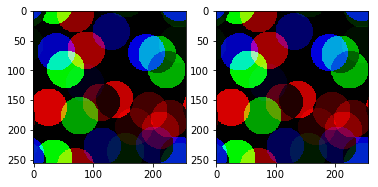

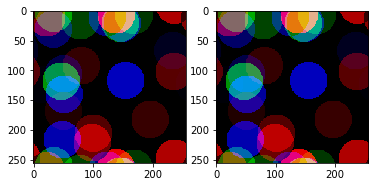

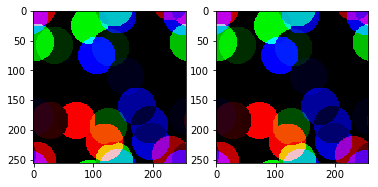

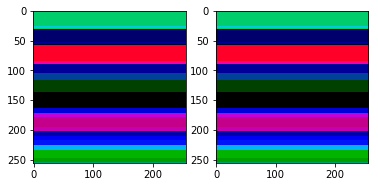

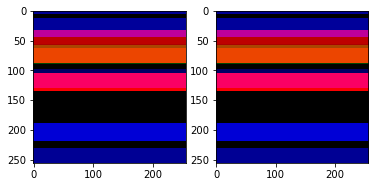

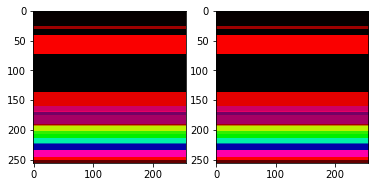

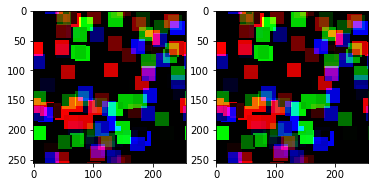

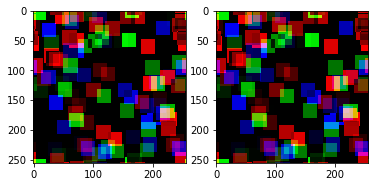

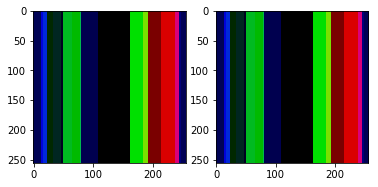

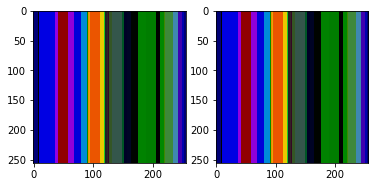

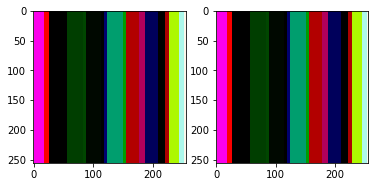

In [14]:
#Resize and store simulated RGB images

simgStkFl = np.zeros([simgStkNo,myDimFl,myDimFl,3])
for c in range(0,simgStkNo):
    myImg = simgStk[c]
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
    myImg = myImg[0:myDim,0:myDim,:]
    myResImg = cv2.resize(myImg,(myDimFl,myDimFl))
    simgStkFl[c] = myResImg
    cv2.imwrite('./sImgs/simulatedImg'+str(c)+'.tif',myResImg)
    if(c % 100 == 0):

        plt.figure()

        plt.subplot(121)
        plt.imshow(simgStk[c])
        plt.subplot(122) 
        plt.imshow(myResImg)
        #plt.colorbar()
        plt.show()

/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


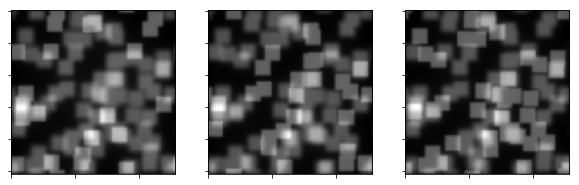

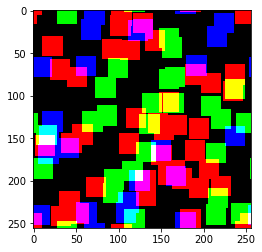

/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


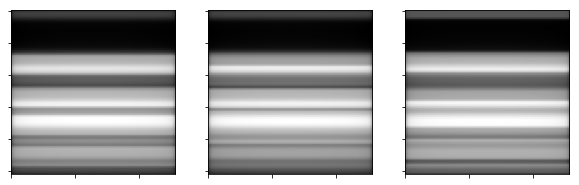

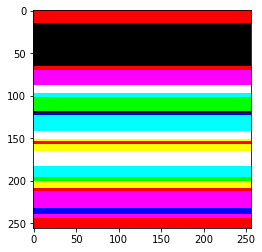

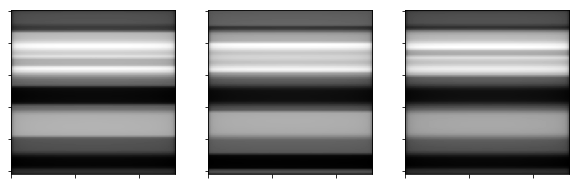

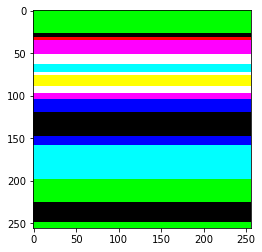

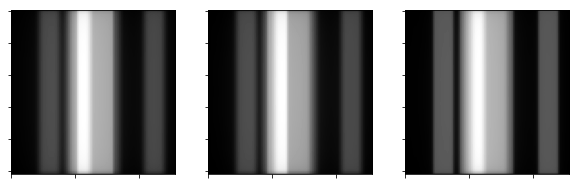

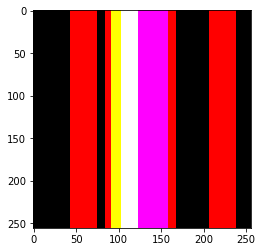

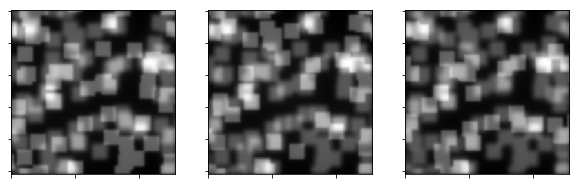

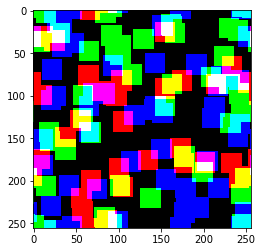

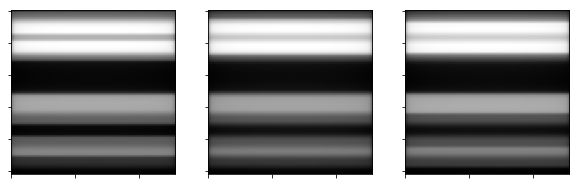

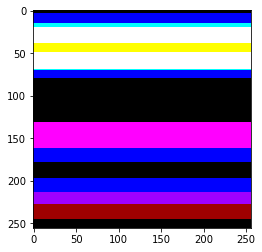

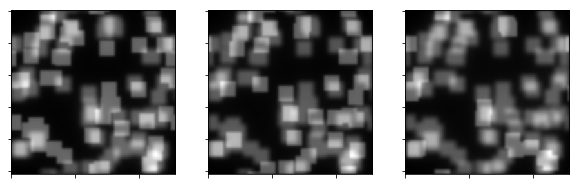

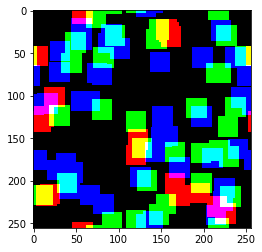

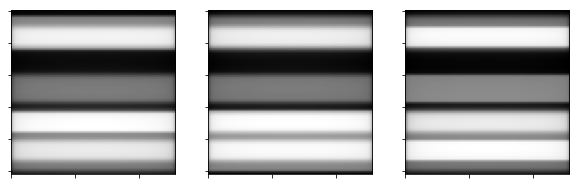

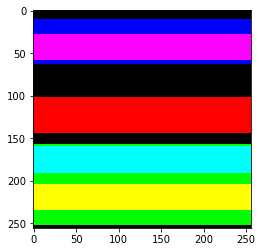

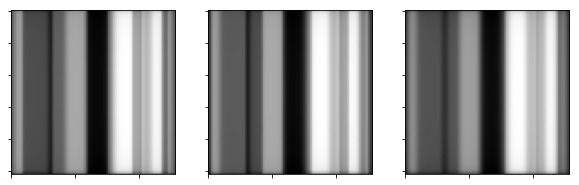

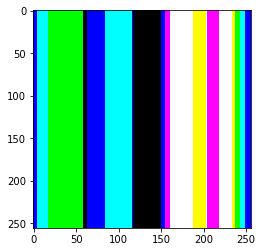

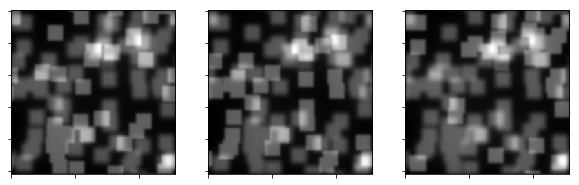

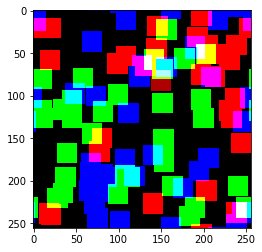

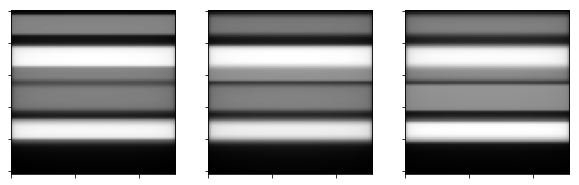

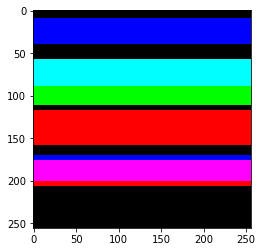

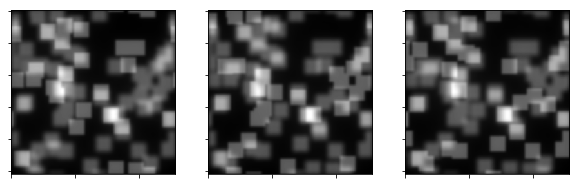

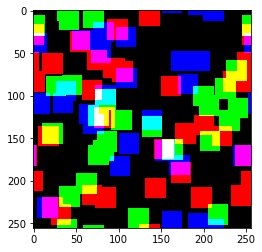

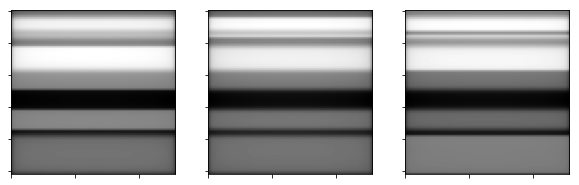

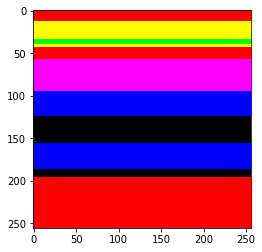

/home/radlr/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/radlr/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


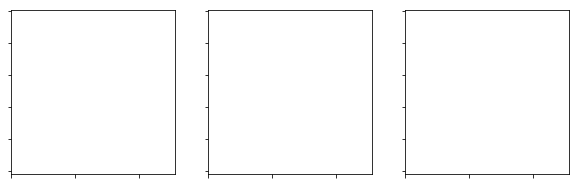

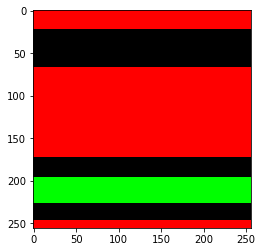

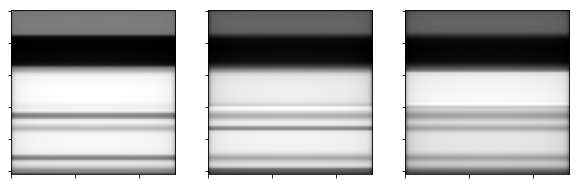

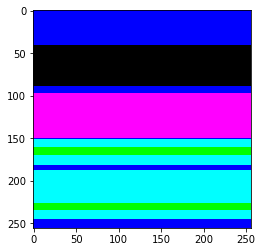

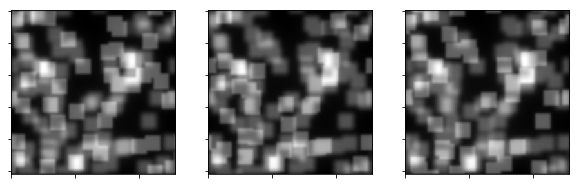

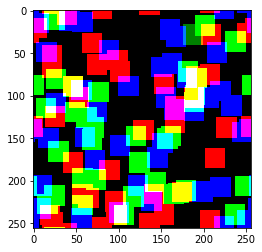

Target vector shape:  (1024, 256, 256, 3)
Training vector shape:  (1024, 256, 256, 3)


In [15]:
# The full-size simulated RGB image stack is the training target
# now to create an input stack using the cuttleVision function

myMiniDir = os.listdir('./sImgs/')
cSpher = 0
nStk = 3
off = 0
defCo = 1e-3
myTargets = []
myImgs = []

#note cv2 to color function for displaying RGB images
#opencv store images as BGR instead of RGB, so we have to fix it
#cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB)
myC = 0 
for k in myMiniDir:
    myC = myC+1 
    #myImg = cv2.imread('./sImgs/' + str(c))
    #print(k)
    #Compute cuttlevision
    imgStk, PSFStk = cuttleVision(cSpher,'./sImgs/'+str(k),nStk,off,defCo)
    #Load target image
    myImg = cv2.imread('./sImgs/'+str(k))
    myImgs.append(np.nan_to_num(imgStk))
    myTargets.append(myImg)
    
    if (( myC % 64)==0):
        myFig, myAxes = plt.subplots(1,3,figsize=(10,10))
        for c in range(0,4):
            #for x in range(0,3):
            #plt.subplot(3,3,c+1)
            if(c < 3):
                myAxes[c].imshow(imgStk[:,:,c],cmap="gray")
                myAxes[c].set_xticklabels([])
                myAxes[c].set_yticklabels([])
            else:
                plt.figure()
                plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
                #myAxes[c].set_xticklabels([])
                #myAxes[c].set_yticklabels([])
            #plt.tight_layout()
        
    
        plt.show()
    
print("Target vector shape: ", np.shape(myTargets))
print("Training vector shape: ", np.shape(myImgs))
            
        

        

In [17]:
myImgs = np.array(myImgs)
myTargets = np.array(myTargets)
myTargets = myTargets/np.max(myTargets)
myImgs = myImgs/np.max(myImgs)

# Save the resized data and labels
np.save('./data/simCVTgts/patternCVTgts.npy',myTargets)
np.save('./data/simCVImgs/patternCVImgs.npy',myImgs)
print("Targets and training stored")

Targets and training stored


In [3]:

t = time.time()

imgWidth = 48
imgHeight = 64
n_visible = imgWidth *imgHeight*3
n_visibleRGB = imgWidth *imgHeight*3
n_hidden = 4096 # 2048 # hidden units
lR = 1e-4
myIter = 1800
dispIt = 180# display every th iteration
dORate = 0.33 # dropout Rate

corruption_level = 0.0

# create node for input data and corruption mask
X = tf.placeholder("float",[None, n_visibleRGB], name='X')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
if(1):
    W_init_max = 4 * np.sqrt(1. / (n_visibleRGB +n_hidden))
    W_init = tf.random_uniform(shape=[n_visibleRGB,n_hidden],
                               minval=-W_init_max,
                               maxval=W_init_max)
    W_init2 = tf.random_uniform(shape=[n_hidden,n_hidden],
                               minval=-W_init_max,
                               maxval=W_init_max)
    W_init3 = tf.random_uniform(shape=[n_hidden,n_hidden],
                               minval=-W_init_max,
                               maxval=W_init_max)
    W_init4 = tf.random_uniform(shape=[n_hidden,n_hidden],
                               minval=-W_init_max,
                               maxval=W_init_max)
    W_init5 = tf.random_uniform(shape=[n_hidden,n_visibleRGB],
                               minval=-W_init_max,
                               maxval=W_init_max)

    W1 = tf.Variable(W_init, name='W1')
    
    W2 = tf.Variable(W_init2, name='W2')
    print(W2.shape)
    W3 = tf.Variable(W_init3, name='W3')
    print(W3.shape)
    
    W4 = tf.Variable(W_init4, name='W4')
    
    print(W4.shape)
    b = tf.Variable(tf.zeros([n_hidden]),name='b')

    W5 = tf.Variable(W_init5,name = 'W5')
    print(W5.shape)
    b_prime = tf.Variable(tf.zeros([n_visibleRGB]), name='b_prime')

def model(X, W1,W2,W3,W4,W5, b, b_prime):
    tilde_X = X #
    H1 = tf.nn.relu(tf.matmul(tilde_X, W1) + b)
    print(H1.shape)
    H2 = tf.nn.relu(tf.matmul(H1,W2)+b)
    H3 = tf.nn.relu(tf.matmul(H2,W3)+b)
    H4 = tf.nn.relu(tf.matmul(H3,W4)+b)
    #print(np.shape(Y))
    
    #print(np.shape(dO1))
    Z = (tf.matmul(H4,W5) + b_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return Z

Z = model(X, W1,W2,W3,W4,W5, b, b_prime)

cost = tf.reduce_sum(tf.pow(X - Z, 2))
if (0):
    train_op = tf.train.RMSPropOptimizer(learning_rate = lR,
                                         decay=0.9,
                                         momentum=0.0,
                                         epsilon=1e-10,
                                         use_locking=False,
                                         centered=False,
                                         name='RMSProp').minimize(cost)
#train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

train_op = tf.train.AdamOptimizer(learning_rate=lR,beta1=0.9,
                                  beta2 = 0.999,epsilon=1e-08,
                                  use_locking=False,
                                  name='Adam').minimize(cost,
                                                        global_step = tf.contrib.framework.get_global_step())

#trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])

trX = np.reshape(myImgs[0:800,:,:,:],[np.shape(myImgs[0:800,:,:,:])[0],n_visibleRGB])
teX = np.reshape(myImgs[801:1023,:,:,:],[np.shape(myImgs[801:1023:,:,:])[0],n_visibleRGB])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {X: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
            lR = lR*0.9999
        if( (i) % dispIt == 0):
            print("learning rate decayed to %e" %(lR))
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={X: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(Z,feed_dict = {X: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight,3)),cmap="gray")
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight,3)),cmap="gray")
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")

print("Finished...")
    

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 9216)
(?, 4096)


InternalError: Failed to create session.

In [13]:
print(np.shape(myImgs))

(4096, 128, 128, 3)


In [51]:
print(np.mean(myImgs))

0.158097509093


In [ ]:

%store myImgs
%store myTargets
print("Targets and training stored")

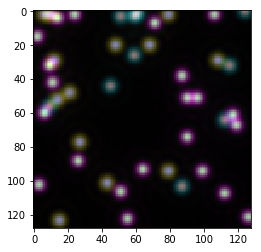

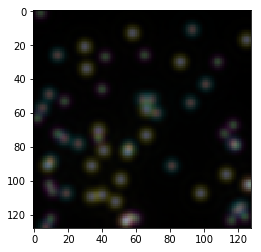

In [12]:
myTest = np.array(myImgs)[125,:]
myTest = myTest / np.max(myTest)
plt.figure()
plt.imshow(myTest)
plt.figure()
plt.imshow(np.array(myImgs)[5,:])
plt.show()

In [ ]:
512*128/2048

In [5]:
"""This version is an autoencoder for the RGB images (eventual targets for cuttleVision)
These heads will later be swapped"""

import tensorflow as tf
import time
t = time.time()

imgWidth = 48
imgHeight = 48
n_visibleRGB = 3*imgWidth *imgHeight
n_hidden = 3072 # hidden units
lR = 1e-5
myIter = int(1e5)
dispIt = 1e4 # display every th iteration
dORate = 0.33 # dropout Rate

corruption_level = 0.0

# create node for input data and corruption mask
XRGB = tf.placeholder("float",[None, n_visibleRGB], name='XRGB')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
WRGB_init = tf.random_uniform(shape=[n_visibleRGB,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

WRGB = tf.Variable(WRGB_init, name='WRGB')
bRGB = tf.Variable(tf.zeros([n_hidden]),name='bRGB')

wRGB_prime = tf.transpose(WRGB)
bRGB_prime = tf.Variable(tf.zeros([n_visibleRGB]), name='bRGB_prime')

def model(XRGB, WRGB, bRGB, WRGB_prime, bRGB_prime):
    tilde_X = XRGB #
    Y = tf.nn.relu(tf.matmul(tilde_X, WRGB) + bRGB)
    #print(np.shape(Y))
    dO1 = tf.nn.dropout(Y,dORate)
    #print(np.shape(dO1))
    ZRGB = tf.nn.relu(tf.matmul(dO1,WRGB_prime) + bRGB_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return ZRGB

ZRGB = model(XRGB, WRGB, bRGB, wRGB_prime, bRGB_prime)

cost = tf.sqrt(tf.sqrt(tf.reduce_mean(tf.pow(XRGB - ZRGB, 2))))
train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

#trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])
trX = np.reshape(myTargets[0:800,:,:,:],[np.shape(myTargets[0:800,:,:,:])[0],n_visibleRGB])
teX = np.reshape(myTargets[801:1023,:,:,:],[np.shape(myTargets[801:1023:,:,:])[0],n_visibleRGB])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {XRGB: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( (1+i) % dispIt == 0):
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={XRGB: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(ZRGB,feed_dict = {XRGB: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight,3)))
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight,3)))
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")


    

IndexError: too many indices for array

In [ ]:
np.sqrt(4)

In [ ]:
"""5 hidden layer autoencoder""""
import tensorflow as tf
import time
t = time.time()

imgWidth = 48
imgHeight = 48
n_visible = imgWidth *imgHeight
n_hidden = 512 # hidden units
lR = 1e-8
myIter = int(2e3)
dispIt = 2e2 # display every th iteration
dORate = 0.33 # dropout Rate

# create node for input data and corruption mask
X = tf.placeholder("float",[None, n_visible], name='X')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
W1_init = tf.random_uniform(shape=[n_visible,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)
W2_init = tf.random_uniform(shape=[n_hidden,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)
W3_init = tf.random_uniform(shape=[n_hidden,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W1 = tf.Variable(W1_init, name='W1')
W2 = tf.Variable(W2_init, name='W2')
W3 = tf.Variable(W2_init, name='W3')

b1 = tf.Variable(tf.zeros([n_hidden]),name='b1')
b2 = tf.Variable(tf.zeros([n_hidden]),name='b1')
b3 = tf.Variable(tf.zeros([n_hidden]),name='b1')

w3_prime = tf.transpose(W3)
w2_prime = tf.transpose(W2)
w1_prime = tf.transpose(W1)

b3_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')
b2_prime = tf.Variable(tf.zeros([n_hidden]), name='b_prime')
b1_prime = tf.Variable(tf.zeros([n_hidden]), name='b_prime')

def model(X, W, b, W_prime, b_prime):
    tilde_X = X #
    Y = tf.nn.relu(tf.matmul(tilde_X, W) + b)
    #print(np.shape(Y))
    dO1 = tf.nn.dropout(Y,dORate)
    #print(np.shape(dO1))
    Z = tf.nn.relu(tf.matmul(dO1,W_prime) + b_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return Z

Z = model(X, W, b, w_prime, b_prime)

cost = tf.reduce_mean(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {X: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( (1+i) % dispIt == 0):
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={X: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(Z,feed_dict = {X: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight)),cmap="gray")
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight)),cmap="gray")
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")


    

In [ ]:
print("finito")

In [ ]:
import time
t = time.time()
print (t)
elapsed = time.time() - t
print(elapsed)

In [ ]:
xTestVis = tf.cast(teX[0:128,:],tf.float32)
print(np.shape(xTestVis))
mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
yPred = model(xTestVis,mask_np,W,b,w_prime,b_prime)
#yPred = np.array([yPred[0]])
print(np.shape(yPred))
#yPredImg = np.reshape(yPred,[64,64])

#yTrueImg = np.reshape(yTrue,[64,64])
test_xs = xTestVis
recon = yPred
fig, axs = plt.subplots(2, 2, figsize=(6, 3))
print(np.shape(test_xs[0]))


for example_i in range(1):
    #print(example_i)
    axs[0][example_i].imshow(
        np.reshape(test_xs, (64, 64)))
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i], (12288,)) + mean_img,
            (32, 32)))

plt.figure()
plt.subplot(121)
plt.imshow(yPredImg)
plt.subplot(122)
plt.imshow(yPredImg)
plt.show()

In [ ]:
print(np.max(myImg))

In [ ]:

mySize = np.shape(myImgs)[0] #length of training image vector

for c in range(0,mySize):
    myImg = myImgs[c,:]
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    
    # This bit crops to a square image if necessary
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
        
    myImg = 255*myImg[0:myDim,0:myDim,:]
    cv2.imwrite('./trainImgs/trainImg'+str(c)+'.tif',myImg)
    
    if(c % 500 == 0):
        print("Saved training img number ", c)
        plt.figure()

        plt.subplot(121)
        plt.imshow(myImg*255)
        plt.subplot(122) 
        plt.imshow(myImg)
        #plt.colorbar()
        plt.show()